In [0]:
!pip install coremltools

     |████████████████████████████████| 3.4MB 4.9MB/s 


In [0]:
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils

In [0]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')
print('keras version ', keras.__version__)
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
TIME_PERIODS = 80
STEP_DISTANCE = 40

keras version  2.2.5


In [0]:
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

In [0]:
!gdown --id 152sWECukjvLerrVG2NUO8gtMFg83RKCF --output WISDM_ar_latest.tar.gz
!tar -xvf WISDM_ar_latest.tar.gz

Downloading...
From: https://drive.google.com/uc?id=152sWECukjvLerrVG2NUO8gtMFg83RKCF
To: /content/WISDM_ar_latest.tar.gz
11.4MB [00:00, 24.5MB/s]
WISDM_ar_v1.1/
WISDM_ar_v1.1/readme.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_raw_about.txt
WISDM_ar_v1.1/WISDM_ar_v1.1_transformed.arff
WISDM_ar_v1.1/WISDM_ar_v1.1_trans_about.txt


In [0]:
column_names = ['user-id', 'activity', 'timestamp', 'x-axis', 'y-axis', 'z-axis']

df = pd.read_csv('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt', header=None, names=column_names)
df['z-axis'].replace(regex=True, inplace=True, to_replace=r';', value=r'')
df['z-axis'] = df['z-axis'].astype(np.float64)
df.dropna(axis=0, how='any', inplace=True)

In [0]:
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203



,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


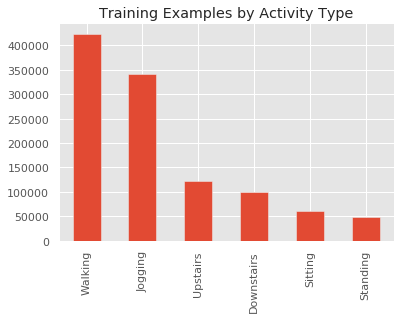

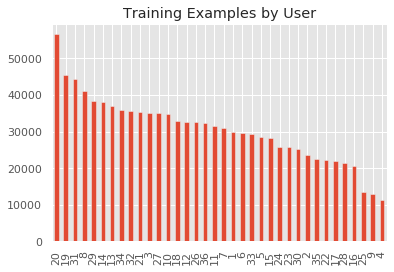

In [0]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

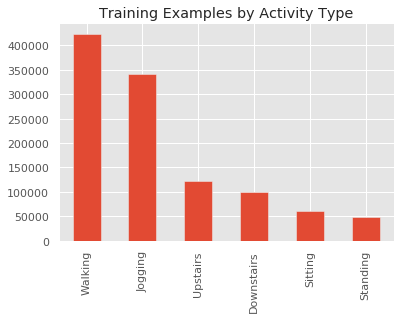

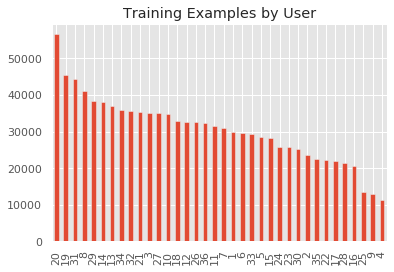

In [0]:
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()

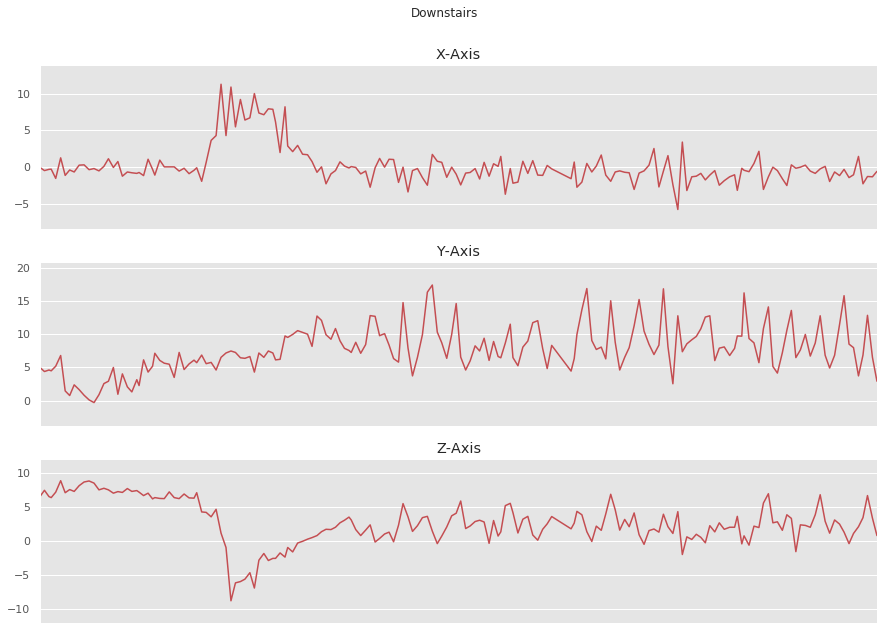

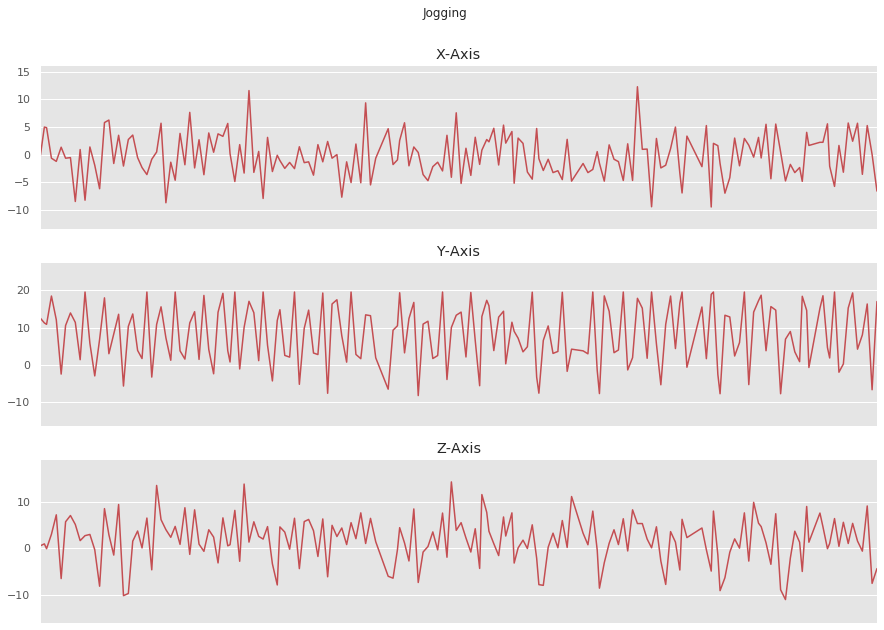

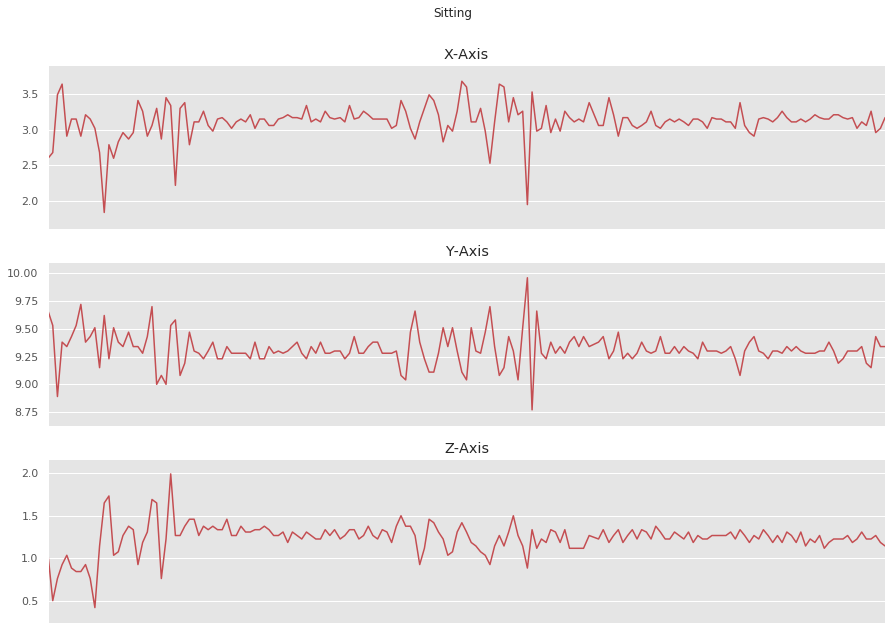

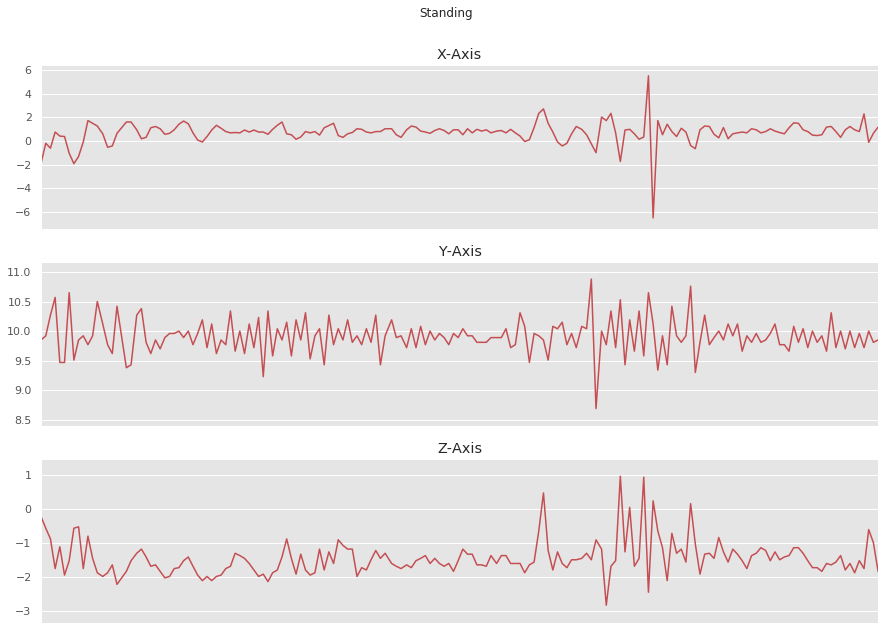

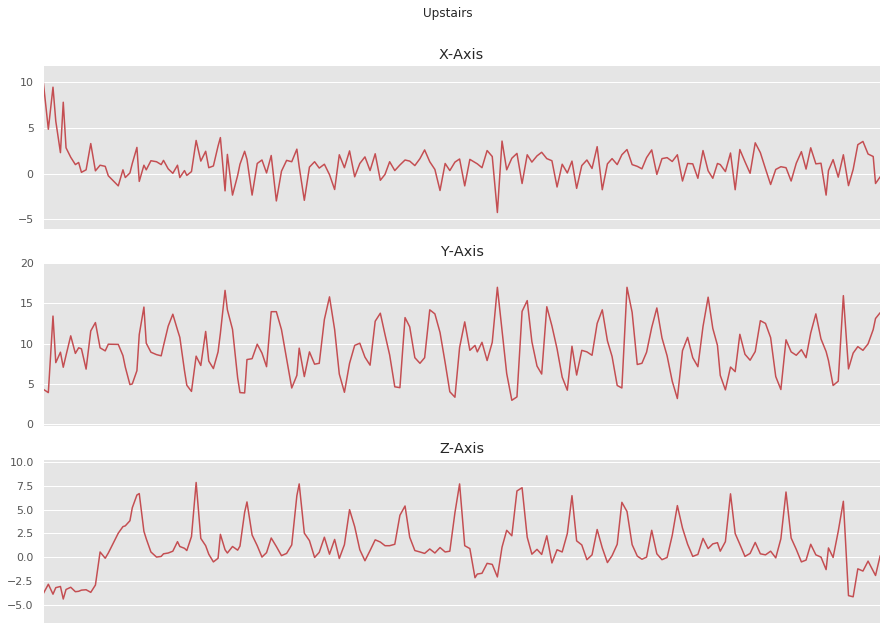

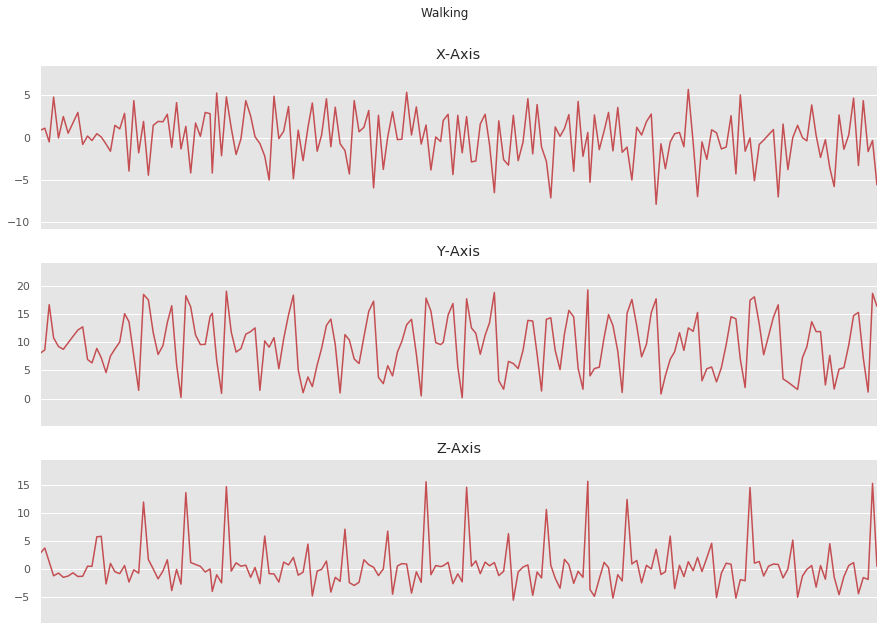

In [0]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

In [0]:
LABEL = 'ActivityEncoded'
le = preprocessing.LabelEncoder()
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [0]:
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [0]:
def create_segments_and_labels(df, time_steps, step, label_name):

    N_FEATURES = 3
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

In [0]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


In [0]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [0]:
input_shape = (num_time_periods*num_sensors)
x_train = x_train.reshape(x_train.shape[0], input_shape)
print('x_train shape:', x_train.shape)
print('input_shape:', input_shape)

x_train shape: (20868, 240)
input_shape: 240


In [0]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

In [0]:
y_train_hot = np_utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [0]:
model_m = Sequential()
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
__________________________________________________

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

BATCH_SIZE = 400
EPOCHS = 500

history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16694 samples, validate on 4174 samples
Epoch 1/500



16694/16694 [==============================] - 8s 458us/step - loss: 1.0842 - acc: 0.6253 - val_loss: 0.7140 - val_acc: 0.8136
Epoch 2/500
16694/16694 [==============================] - 7s 397us/step - loss: 0.5982 - acc: 0.7849 - val_loss: 0.6502 - val_acc: 0.8215
Epoch 3/500
16694/16694 [==============================] - 7s 394us/step - loss: 0.5186 - acc: 0.8120 - val_loss: 0.6862 - val_acc: 0.7774
Epoch 4/500
16694/16694 [==============================] - 7s 446us/step - loss: 0.4847 - acc: 0.8225 - val_loss: 0.6266 - val_acc: 0.8304
Epoch 5/500
16694/16694 [==============================] - 7s 396us/step - loss: 0.4615 - acc: 0.8320 - val_loss: 0.6417 - val_acc: 0.8165
Epoch 6/500
16694/16694 [==============================] - 7s 394us/step - loss: 0.4415 - acc: 0.8390 - val_loss: 0.6510 - val_acc: 0.8083
Epoch 7/500
16694/16694 [==============================] - 7s 403us/step - loss: 0.4264 - acc: 0.8463 - val_loss: 0.6519 - val_acc: 0.8050
Epoch 8/500
16694/16694 [==============

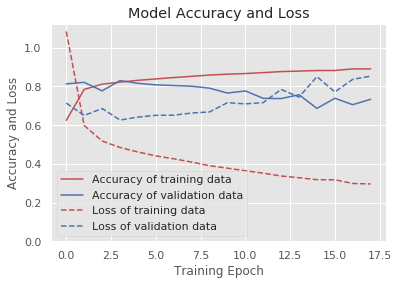

              precision    recall  f1-score   support

         0.0       0.68      0.40      0.50      1864
         1.0       0.96      0.99      0.97      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      0.99      0.99       833
         4.0       0.58      0.71      0.64      2342
         5.0       0.88      0.89      0.88      8212

    accuracy                           0.86     20868
   macro avg       0.85      0.83      0.83     20868
weighted avg       0.86      0.86      0.86     20868



In [0]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

y_pred_train = model_m.predict(x_train)
max_y_pred_train = np.argmax(y_pred_train, axis=1)
print(classification_report(y_train, max_y_pred_train))

In [0]:
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.reshape(x_test.shape[0], input_shape)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

y_test = np_utils.to_categorical(y_test, num_classes)

score = model_m.evaluate(x_test, y_test, verbose=1)

print('\nAccuracy on test data: %0.2f' % score[1])
print('\nLoss on test data: %0.2f' % score[0])

6584/6584 [==============================] - 1s 161us/step

Accuracy on test data: 0.72

Loss on test data: 1.36


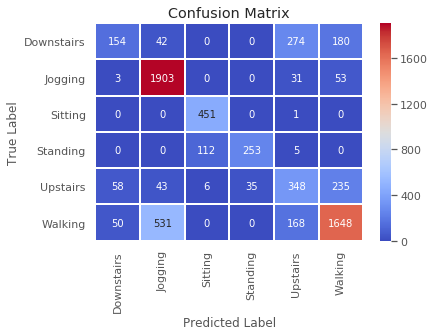

              precision    recall  f1-score   support

           0       0.58      0.24      0.34       650
           1       0.76      0.96      0.84      1990
           2       0.79      1.00      0.88       452
           3       0.88      0.68      0.77       370
           4       0.42      0.48      0.45       725
           5       0.78      0.69      0.73      2397

    accuracy                           0.72      6584
   macro avg       0.70      0.67      0.67      6584
weighted avg       0.72      0.72      0.71      6584



In [0]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

y_pred_test = model_m.predict(x_test)
max_y_pred_test = np.argmax(y_pred_test, axis=1)
max_y_test = np.argmax(y_test, axis=1)

show_confusion_matrix(max_y_test, max_y_pred_test)

print(classification_report(max_y_test, max_y_pred_test))

In [0]:
coreml_model = coremltools.converters.keras.convert(model_m,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)

print(coreml_model)
coreml_model.author = 'Nils Ackermann'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x7fc85d7e59b0>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7fc85d7e56d8>
2 : dense_1, <keras.layers.core.Dense object at 0x7fc85d7e5978>
3 : dense_1__activation__, <keras.layers.core.Activation object at 0x7fc85b131e80>
4 : dense_2, <keras.layers.core.Dense object at 0x7fc85d751e10>
5 : dense_2__activation__, <keras.layers.core.Activation object at 0x7fc85b131be0>
6 : dense_3, <keras.layers.core.Dense object at 0x7fc85c511240>
7 : dense_3__activation__, <keras.layers.core.Activation object at 0x7fc85b131f60>
8 : flatten_1, <keras.layers.core.Flatten object at 0x7fc85d762a90>
9 : dense_4, <keras.layers.core.Dense object at 0x7fc85d76c0f0>
10 : dense_4__activation__, <keras.layers.core.Activation object at 0x7fc85b131f98>
input {
  name: "acceleration"
  type {
    multiArrayType {
      shape: 240
      dataType: DOUBLE
    }
  }
}
output {
  name: "output"
  type {
    dictionaryType {
      stringKeyType {


In [0]:
print('\nPrediction from Keras:')
test_record = x_test[1].reshape(1,input_shape)
keras_prediction = np.argmax(model_m.predict(test_record), axis=1)
print(le.inverse_transform(keras_prediction)[0])



Prediction from Keras:
Jogging
